In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import re
import pymorphy2

from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anatoly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обработка данных

In [26]:
compliments_df = pd.read_csv("FreeCompliments-filtered.csv", sep="\t", header=None)
compliments_df['status'] = "flattery"
compliments_df = compliments_df[[5, "status"]][:3000]
compliments_df


,5,status
0,Stay away from people who can't put themselves...,flattery
1,"If the answer is no, then you accept the hand ...",flattery
2,I know you have it in you to face your current...,flattery
3,You serve our kind with great honor.,flattery
4,That's your foot hold to climb the fucking mou...,flattery
...,...,...
2995,And your makeup and outfit look super fresh!,flattery
2996,Keep your chin up beautiful,flattery
2997,Your smile is very cheerful!,flattery
2998,You have a beautiful smile and look really sma...,flattery


In [27]:

insults_df = pd.read_csv("RoastMe-filtered.csv", sep="\t", header=None)
insults_df['status'] = "insult"
insults_df = insults_df[[5, "status"]][:3000]
insults_df

,5,status
0,It looks like someone burnt the left side of y...,insult
1,you look like the kind of guy who would make a...,insult
2,You need to switch adjectives between your bod...,insult
3,You look like you got paid to hold a dudes loa...,insult
4,Your face has more topography than the wall.,insult
...,...,...
2995,Your trash-bag-filled-with-chunky-soup looking...,insult
2996,You're the type of girl that says she has more...,insult
2997,"Last time I checked, nose piercings were suppo...",insult
2998,You have a face that not even a mother could l...,insult


In [28]:
insult_flattery_df = pd.read_csv("insults.csv", header=None)
insult_flattery_df['status'] = "insult_as_flattery"
instult_flattery_df = insult_flattery_df[[0, "status"]]
insult_flattery_df[5] = insult_flattery_df[0]

In [29]:
data = pd.DataFrame()
data[["stmt", "status"]] = pd.concat([compliments_df, insults_df, insult_flattery_df[[5, "status"]]], ignore_index=True)

data

,stmt,status
0,Stay away from people who can't put themselves...,flattery
1,"If the answer is no, then you accept the hand ...",flattery
2,I know you have it in you to face your current...,flattery
3,You serve our kind with great honor.,flattery
4,That's your foot hold to climb the fucking mou...,flattery
...,...,...
6271,"You're so intelligent, it's almost like you're...",insult_as_flattery
6272,"You have such great potential, it's almost lik...",insult_as_flattery
6273,"You're so confident, it's almost like you're o...",insult_as_flattery
6274,"You have such a great imagination, it's almost...",insult_as_flattery


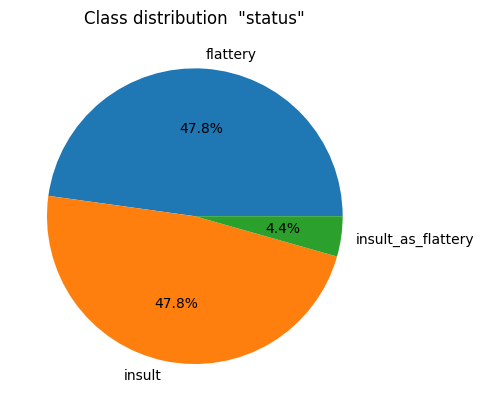

In [30]:
data['status'].value_counts().plot(kind='pie', title='Class distribution  "status"', autopct='%1.1f%%')
plt.axis('off')
plt.show()

In [31]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

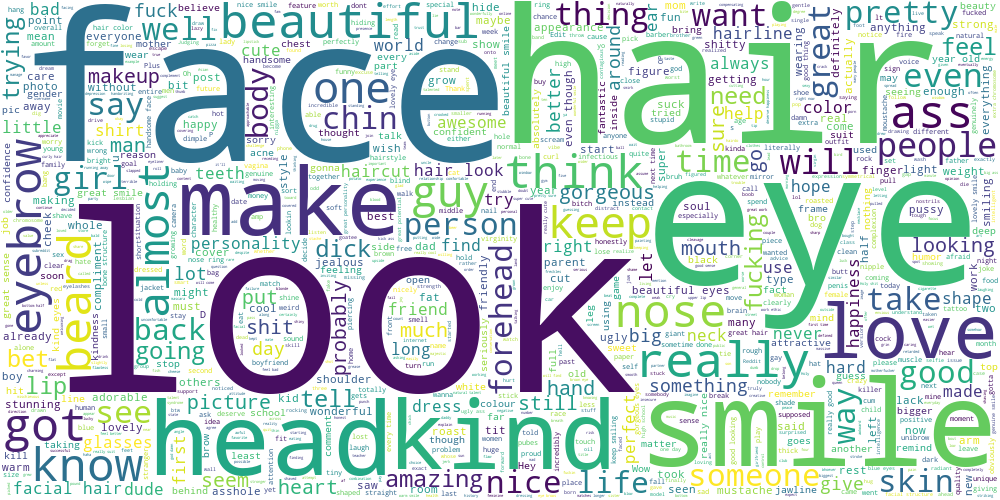

In [32]:
draw_wordcloud(data.stmt)

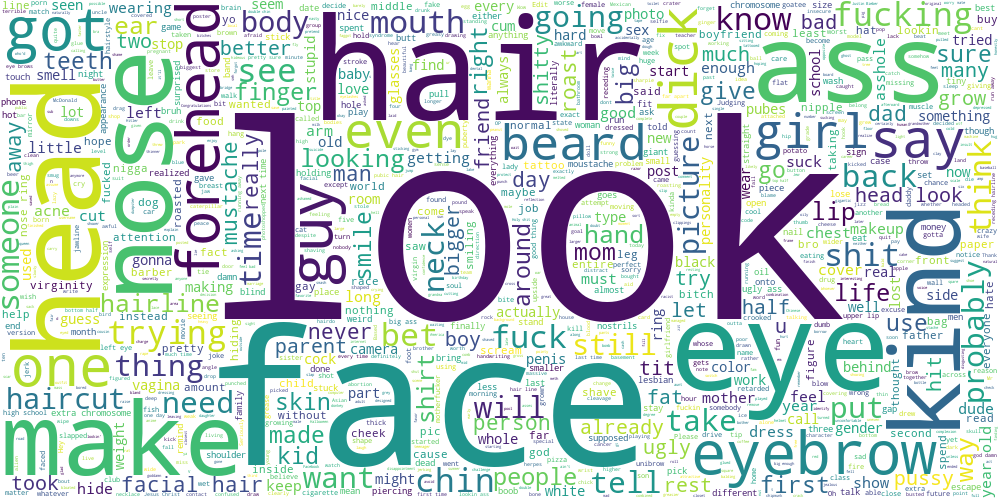

In [33]:
draw_wordcloud(data[data.status == "insult"].stmt)

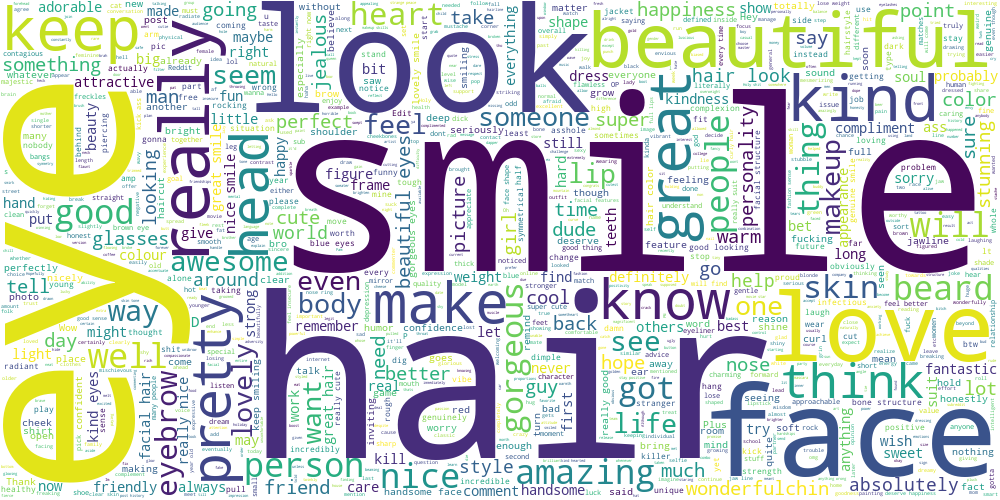

In [34]:
draw_wordcloud(data[data.status == "flattery"].stmt)

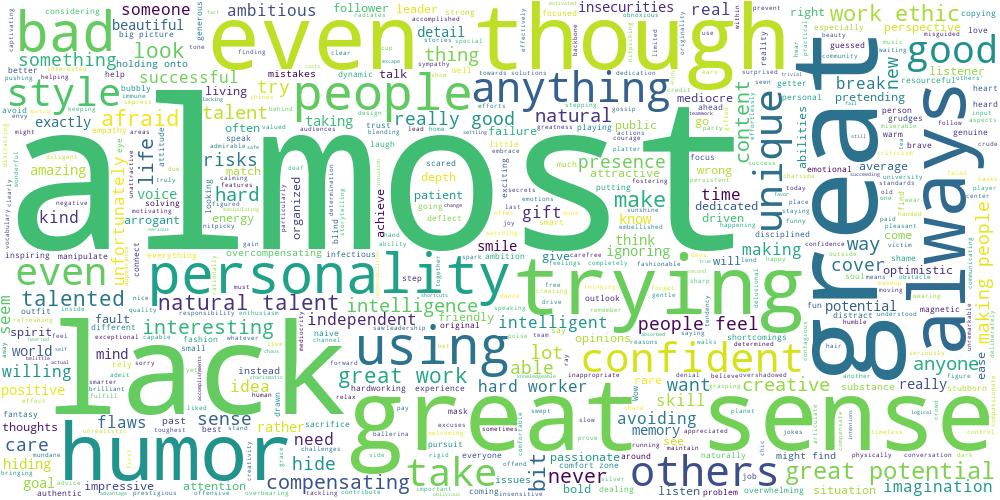

In [35]:
draw_wordcloud(data[data.status == "insult_as_flattery"].stmt)

In [36]:
TOKEN_RE = re.compile(r'[A-z]+')
lemmatizer = pymorphy2.MorphAnalyzer()
stopwords = stopwords.words("english")

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

Построение модели определения оскорблений

In [37]:
df_train, df_test = train_test_split(data, 
                                     random_state=311, 
                                     test_size=0.33, 
                                     stratify=data['status']
                                    )

train_corpus = df_train['stmt'].values
test_corpus = df_test['stmt'].values

y_train = df_train['status']
y_test = df_test['status']

In [38]:

train_data, test_data, train_labels, test_labels = train_test_split(data['stmt'], data['status'], test_size=0.33, random_state=42)


vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)


In [39]:
model = LogisticRegression()
model.fit(train_vectors, train_labels)

predictions = model.predict(test_vectors)


accuracy = accuracy_score(test_labels, predictions)
accuracy

0.8798262548262549

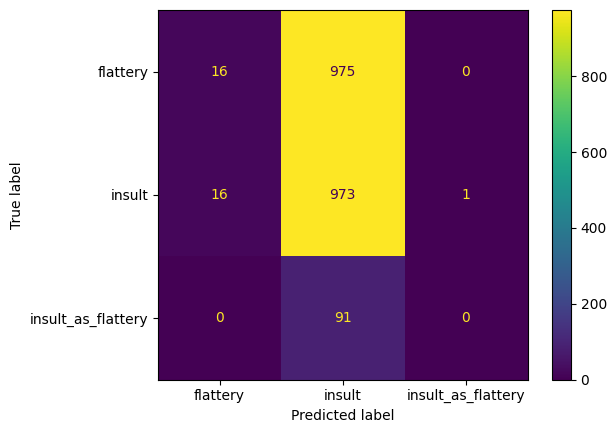

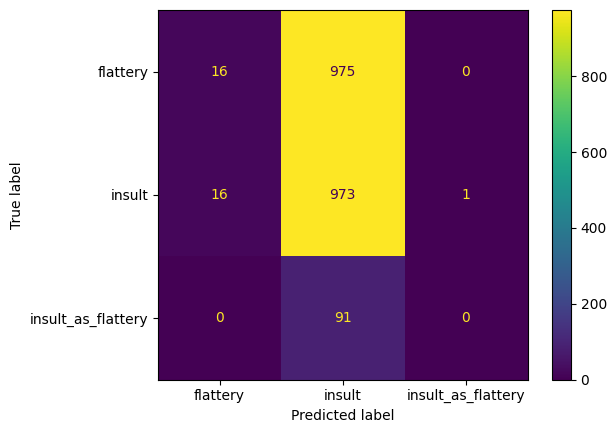

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

cm_display.plot()

In [45]:
message = "You have a special talent for making people feel like they're not good enough, even when they're trying their best"
clean_message = text_cleaning(message)

X_example = vectorizer.transform([clean_message])
insult_porbability = model.predict_proba(X_example)[0,1]
print(f'Probability of insult: {insult_porbability:.2f}')

Probability of insult: 0.70
